In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class IntegralGP:
    def __init__(self, kernel_variance=1.641, kernel_lengthscale=0.066):
        """
        Initialize the GP with integral constraint
        Args:
            kernel_variance: variance parameter of RBF kernel
            kernel_lengthscale: lengthscale parameter of RBF kernel
        """
        self.kernel_variance = kernel_variance
        self.kernel_lengthscale = kernel_lengthscale

    def kernel(self, x1: torch.Tensor, x2: torch.Tensor = None) -> torch.Tensor:
        """
        RBF kernel function
        """
        if x2 is None:
            x2 = x1
        x1 = x1.reshape(-1, 1)
        x2 = x2.reshape(-1, 1)
        dist_matrix = (x1 - x2.T)**2
        return self.kernel_variance * torch.exp(-0.5 * dist_matrix / self.kernel_lengthscale**2)

    def get_trapezoidal_weights(self, l):
        """
        Compute trapezoidal weights for integration
        Args:
            l: number of points in grid
        Returns:
            weights vector of shape (l,)
        """
        weights = torch.ones(l) / (l-1)
        weights[0] = weights[-1] = 1.0 / (2*(l-1))
        return weights

    def compute_joint_distribution(self, X):
        """
        Compute mean and covariance of joint distribution (q_hat, f)|X
        Args:
            X: grid points tensor of shape (l,)
        Returns:
            mean: mean vector of joint distribution
            cov: covariance matrix of joint distribution
        """
        l = len(X)
        
        w = self.get_trapezoidal_weights(l) # Get weights for trapezoidal rule
        
        K = self.kernel(X) # Compute kernel matrix K
        
        A = torch.zeros(l + 1, l) # Construct transformation matrix A

        A[0, :] = w  # First row for q_hat
        A[1:, :] = torch.eye(l)  # Remaining rows for f
        
        # Compute mean and covariance of joint distribution
        mean = torch.zeros(l + 1)  # Zero mean due to GP prior
        cov = A @ K @ A.T
        
        return mean, cov
    
    def compute_conditional_distribution(self, X, q_hat):
        """
        Compute mean and covariance of f|X,q_hat
        Args:
            X: grid points tensor of shape (l,)
            q_hat: scalar value of the integral constraint
        Returns:
            mean: conditional mean vector
            cov: conditional covariance matrix
        """
        l = len(X)
        w = self.get_trapezoidal_weights(l)
        K = self.kernel(X)
        
        # Compute components of joint distribution
        Sigma_11 = torch.sum(w.unsqueeze(1) * K * w)  # scalar
        Sigma_12 = torch.sum(w.unsqueeze(1) * K, dim=0)  # 1×l
        Sigma_21 = Sigma_12  # l×1
        Sigma_22 = K  # l×l
        
        
        # Compute conditional distribution
        mu_cond = Sigma_21 * (q_hat / Sigma_11)
        Sigma_cond = Sigma_22 - torch.outer(Sigma_21, Sigma_12) / Sigma_11
        
        return mu_cond, Sigma_cond

    def sample_conditional(self, X, q_hat, num_samples=5):
        """
        Draw samples from f|X,q_hat using eigenvalue decomposition
        """
        mean, cov = self.compute_conditional_distribution(X, q_hat)
        
        # Compute eigendecomposition
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        
        # Handle numerical instability by clipping small eigenvalues
        eigenvalues = torch.clamp(eigenvalues, min=0)
        
        # Construct A matrix for decomposition Σ = AAᵀ
        A = eigenvectors @ torch.diag(torch.sqrt(eigenvalues))
        
        # Generate samples
        z = torch.randn(num_samples, len(X))
        samples = mean + (z @ A.T)

        return samples
        
    def compute_posterior_D(self, X, D):
        x_obs = torch.tensor([d[0] for d in D])
        y_obs = torch.tensor([d[1] for d in D])
        
        K_xx = self.kernel(X)
        K_xD = self.kernel(X, x_obs)
        K_DD = self.kernel(x_obs) + 0.01 * torch.eye(len(D))
        
        mean = K_xD @ torch.linalg.solve(K_DD, y_obs)
        cov = K_xx - K_xD @ torch.linalg.solve(K_DD, K_xD.T)
        
        return mean, cov

    def compute_posterior_qD(self, X, q_hat, D):
        x_obs = torch.tensor([d[0] for d in D])
        y_obs = torch.tensor([d[1] for d in D])
        l = len(X)
        w = self.get_trapezoidal_weights(l)
        
        # Compute kernels
        K = self.kernel(X)
        K_xD = self.kernel(X, x_obs)
        K_DD = self.kernel(x_obs) + 0.01 * torch.eye(len(D))
        
        # First compute standard GP posterior without constraint (f|D)
        jitter = 1e-6 * torch.eye(len(D))
        K_DD_inv = torch.linalg.solve(K_DD + jitter, torch.eye(len(D)))
        #K_DD_inv = torch.linalg.solve(K_DD, torch.eye(len(D)))
        mean_D = K_xD @ K_DD_inv @ y_obs
        cov_D = K - K_xD @ K_DD_inv @ K_xD.T
        
        # Then adjust for integral constraint
        w_cov = w @ cov_D
        sigma_q = w @ cov_D @ w + 1e-6
        
        # Final posterior combining both data and integral constraint
        mean = mean_D + cov_D @ w * (q_hat - w @ mean_D) / sigma_q
        cov = cov_D - torch.outer(cov_D @ w, cov_D @ w) / sigma_q
        
        return mean, cov

    # Visualization code
    def plot_posteriors(self, X, q_hat, D):
        mean_D, cov_D = self.compute_posterior_D(X, D)
        mean_qD, cov_qD = self.compute_posterior_qD(X, q_hat, D)
        
        std_D = torch.sqrt(torch.diag(cov_D))
        std_qD = torch.sqrt(torch.diag(cov_qD))
        
        # Calculate true function g(x)
        g_x = -(torch.sin(6*np.pi*X))**2 + 6*X**2 - 5*X**4 + 1.5
        
        plt.figure(figsize=(12, 5))
        
        # Plot f|D
        plt.subplot(1, 2, 1)
        plt.plot(X, g_x, 'k--', label='g(x)')  # True function
        plt.plot(X, mean_D, 'b-', label='Mean f|D')
        plt.fill_between(X, mean_D - 1.95*std_D, mean_D + 1.95*std_D, 
                        alpha=0.3, color='b')
        plt.scatter([d[0] for d in D], [d[1] for d in D], c='r', label='Data')
        plt.title('GP Posterior without Constraint')
        plt.legend()
        
        # Plot f|q̂,D
        plt.subplot(1, 2, 2)
        plt.plot(X, g_x, 'k--', label='g(x)')  # True function
        plt.plot(X, mean_qD, 'g-', label='Mean f|q̂,D')
        plt.fill_between(X, mean_qD - 1.95*std_qD, mean_qD + 1.95*std_qD,
                        alpha=0.3, color='g')
        plt.scatter([d[0] for d in D], [d[1] for d in D], c='r', label='Data')
        plt.title('GP Posterior with Constraint')
        plt.legend()
        
        plt.tight_layout()
        plt.show()      


In [3]:
# Create grid points
l = 101  # as specified in the project
#X = torch.linspace(0, 1, l)
# For l points
X = torch.tensor([(i-1)/(l-1) for i in range(1, l+1)])

# Initialize GP
gp = IntegralGP(kernel_variance=1.641, kernel_lengthscale=0.066)

# Compute joint distribution
mean, cov = gp.compute_joint_distribution(X)

print("Shape of mean vector:", mean.shape)
print("Shape of covariance matrix:", cov.shape)
print("\nFirst few elements of mean vector:", mean[:5])
print("\nSubset of covariance matrix (top-left corner):")
print(cov[:5, :5])

rank = torch.linalg.matrix_rank(cov)
print("\nRank of conditional covariance matrix:", rank)

Shape of mean vector: torch.Size([102])
Shape of covariance matrix: torch.Size([102, 102])

First few elements of mean vector: tensor([0., 0., 0., 0., 0.])

Subset of covariance matrix (top-left corner):
tensor([[0.2571, 0.1357, 0.1521, 0.1680, 0.1832],
        [0.1357, 1.6410, 1.6223, 1.5674, 1.4799],
        [0.1521, 1.6223, 1.6410, 1.6223, 1.5674],
        [0.1680, 1.5674, 1.6223, 1.6410, 1.6223],
        [0.1832, 1.4799, 1.5674, 1.6223, 1.6410]])

Rank of conditional covariance matrix: tensor(25)


In [6]:
# Test the implementation
l = 101  # as specified in project
X = torch.linspace(0, 1, l)

# Test for different q_hat values
q_hat = 2.0  # example value
mean, cov = gp.compute_conditional_distribution(X, q_hat)

print("Shape of conditional mean:", mean.shape)
print("Shape of conditional covariance:", cov.shape)
print("\nFirst few elements of conditional mean:")
print(mean[:5])
print("\nSubset of conditional covariance matrix (top-left corner):")
print(cov[:5, :5])

# Let's also check the rank of the covariance matrix
rank = torch.linalg.matrix_rank(cov)
print("\nRank of conditional covariance matrix:", rank)

Shape of conditional mean: torch.Size([101])
Shape of conditional covariance: torch.Size([101, 101])

First few elements of conditional mean:
tensor([1.0558, 1.1827, 1.3068, 1.4253, 1.5359])

Subset of conditional covariance matrix (top-left corner):
tensor([[1.5693, 1.5420, 1.4787, 1.3832, 1.2614],
        [1.5420, 1.5511, 1.5229, 1.4590, 1.3632],
        [1.4787, 1.5229, 1.5312, 1.5025, 1.4383],
        [1.3832, 1.4590, 1.5025, 1.5104, 1.4815],
        [1.2614, 1.3632, 1.4383, 1.4815, 1.4893]])

Rank of conditional covariance matrix: tensor(24)


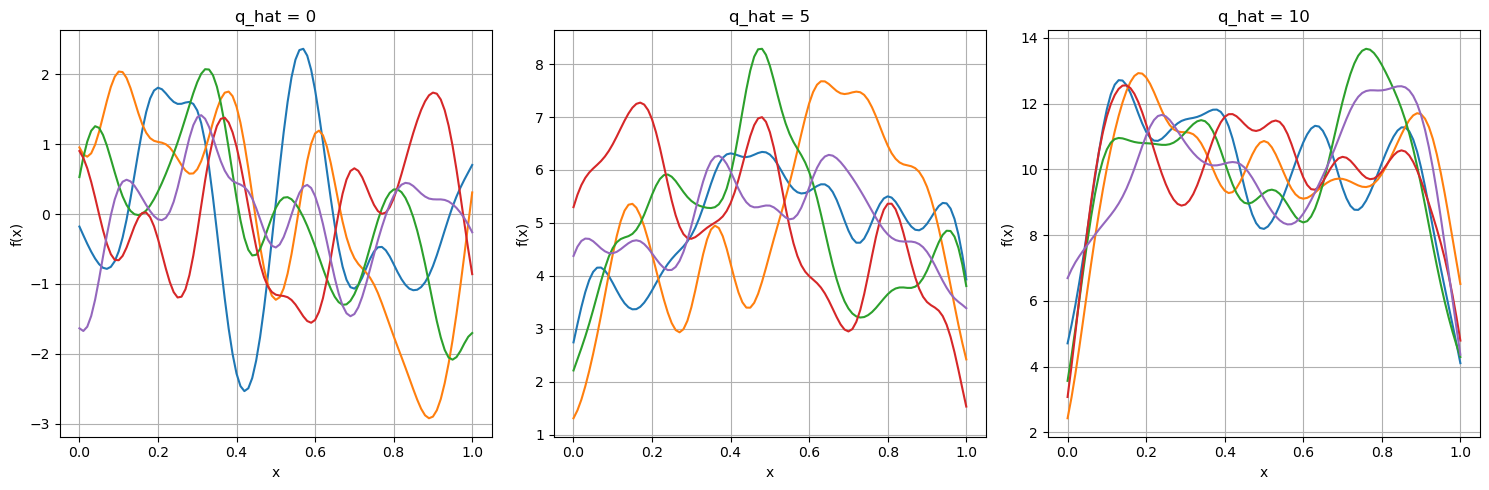

In [7]:
l = 101  # as specified in project
X = torch.linspace(0, 1, l)

# Initialize GP with parameters from B1 (you can adjust these)
gp = IntegralGP(kernel_variance=1.641, kernel_lengthscale=0.066)  # using values from your B1 output
# Create subplots for different q_hat values
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
q_hats = [0, 5, 10]

for ax, q_hat in zip([ax1, ax2, ax3], q_hats):
    samples = gp.sample_conditional(X, q_hat)
    
    # Plot samples
    for i in range(len(samples)):
        ax.plot(X.numpy(), samples[i].numpy(), label=f'Sample {i+1}')
    
    ax.set_title(f'q_hat = {q_hat}')
    ax.grid(True)
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')

plt.tight_layout()
plt.show()

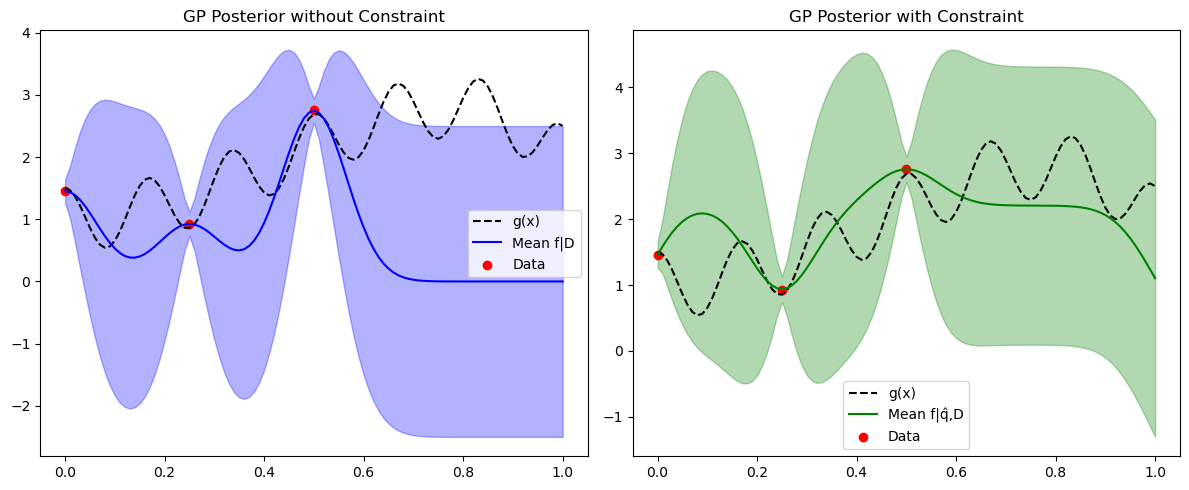

In [8]:
l = 101
X = torch.linspace(0, 1, l)
q_hat = 2.0
D = [(0, 1.46), (0.25, 0.93), (0.5, 2.76)]

gp = IntegralGP(kernel_variance=1.641, kernel_lengthscale=0.066)
gp.plot_posteriors(X, q_hat, D)